# Preprocessing of MRNet and Data Augmentation

In [75]:
import os
import pickle
import platform
from glob import glob
import numpy as np
import pandas as pd


In [76]:
from scipy import ndimage
import SimpleITK as sitk

In [78]:
# Directory where the volumetric data is located
kneemri_data_dir = '/kaggle/input/kneemridataset'

# Path to metadata csv file
kneemri_metadata_csv_path = '/kaggle/input/kneemridataset/metadata.csv'

In [79]:
# For running code on Windows
if platform.system() == "Windows":
    kneemri_data_dir = kneemri_data_dir.replace('/', '\\')
    kneemri_metadata_csv_path = kneemri_metadata_csv_path.replace('/', '\\')

In [80]:
# Dataset label meanings
kneemri_labels = {0: 'healthy', 1: 'partially ruptured', 2: 'completely ruptured'}

In [81]:
if platform.system() == "Windows":
    mri_vol_paths = glob(kneemri_data_dir + "\\vol*")
else:
    mri_vol_paths = glob(kneemri_data_dir + "/vol*")
mri_vol_paths.sort()

In [82]:
mri_vol_paths

['/kaggle/input/kneemridataset/vol01',
 '/kaggle/input/kneemridataset/vol02',
 '/kaggle/input/kneemridataset/vol03',
 '/kaggle/input/kneemridataset/vol04',
 '/kaggle/input/kneemridataset/vol05',
 '/kaggle/input/kneemridataset/vol06',
 '/kaggle/input/kneemridataset/vol07',
 '/kaggle/input/kneemridataset/vol08']

In [83]:
# names=True loads the interprets the first row of csv file as column names
# 'i4' = 4 byte signed integer, 'U20' = unicode max 20 char string
metadata = np.genfromtxt(kneemri_metadata_csv_path, delimiter=',', names=True,
                         dtype='i4,i4,i4,i4,i4,i4,i4,i4,i4,i4,U20')

In [85]:
metadata_df = pd.DataFrame(metadata)

In [87]:
metadata_df

,examId,seriesNo,aclDiagnosis,kneeLR,roiX,roiY,roiZ,roiHeight,roiWidth,roiDepth,volumeFilename
0,329637,8,0,1,139,184,14,74,72,3,329637-8.pck
1,390116,9,0,0,113,105,10,83,98,6,390116-9.pck
2,404663,8,1,1,120,117,15,101,115,2,404663-8.pck
3,406320,9,0,0,117,124,12,91,80,3,406320-9.pck
4,412857,8,0,1,122,105,14,83,98,4,412857-8.pck
...,...,...,...,...,...,...,...,...,...,...,...
912,1027212,5,1,1,113,127,16,101,99,3,1027212-5.pck
913,1028019,5,1,1,105,102,14,95,100,3,1028019-5.pck
914,1028028,5,0,0,118,84,15,100,100,2,1028028-5.pck
915,1028069,5,0,0,105,97,15,103,106,4,1028069-5.pck


In [89]:
metadata_df
def resize_3D_volume(vol, target_size=(30, 256, 256)):
    """
    Given a 3D volumteric array with shape (Z,X,Y). This function will resize
    the image across z-axis.
    The purpose of this function to standardise the depth of MRI image.

    Args:
        vol: 3D array with shape (Z,X,Y) that represents the volume of a MRI image
        target_size: target size to shape into the volumetric data

    Returns:
        np.ndarray: Returns the resized MRI volume
    """
    # Set the desired depth
    desired_depth, desired_width, desired_height = target_size
    # Get current depth
    current_depth = vol.shape[0]
    current_width = vol.shape[1]
    current_height = vol.shape[2]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Resize across z-axis
    resized_vol = ndimage.zoom(vol, (depth_factor, width_factor, height_factor), order=1)
    return resized_vol


In [91]:

def resize_3D_volume(vol, target_size=(30, 256, 256)):
    """
    Given a 3D volumteric array with shape (Z,X,Y). This function will resize
    the image across z-axis.
    The purpose of this function to standardise the depth of MRI image.

    Args:
        vol: 3D array with shape (Z,X,Y) that represents the volume of a MRI image
        target_size: target size to shape into the volumetric data

    Returns:
        np.ndarray: Returns the resized MRI volume
    """
    # Set the desired depth
    desired_depth, desired_width, desired_height = target_size
    # Get current depth
    current_depth = vol.shape[0]
    current_width = vol.shape[1]
    current_height = vol.shape[2]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Resize across z-axis
    resized_vol = ndimage.zoom(vol, (depth_factor, width_factor, height_factor), order=1)
    return resized_vol


In [92]:
def denoise_3D_volume(vol):
    """Summary

    Args:
        vol (np.ndarray): MRI volume to denoise

    Returns:
        np.ndarray: Returns denoised MRI volume
    """
    vol_sitk = sitk.GetImageFromArray(vol)
    denoised_vol_sitk = sitk.CurvatureFlow(vol_sitk, timeStep=0.01, numberOfIterations=7)
    denoised_vol = sitk.GetArrayFromImage(denoised_vol_sitk)
    return denoised_vol

In [93]:

def normalise_volume_pixels(vol):
    """Summary

    Args:
        vol (np.ndarray): MRI volume

    Returns:
        np.ndarray: Normalised MRI volume
    """
    # Normalise the volume pixels to the range [0, 1]
    min_value = np.min(vol)
    max_value = np.max(vol)
    normalised_vol = (vol - min_value) / (max_value - min_value)

    return normalised_vol


In [94]:


def center_volume_pixels(vol):
    """Summary

    Args:
        vol (np.ndarray): MRI volume

    Returns:
        np.ndarray: Zero centered MRI volume
    """
    # Calculate the mean value
    mean_value = np.mean(vol)

    # Center the data
    centered_vol = vol - mean_value

    return centered_vol

In [95]:

def standardise_volume_pixels(vol):
    """Summary

    Args:
        vol (np.ndarray): MRI volume

    Returns:
        np.ndarray: Standardised MRI volume
    """
    # Calculate the mean and standard deviation
    mean_value = np.mean(vol)
    std_value = np.std(vol)

    # Standardise the data
    standardised_vol = (vol - mean_value) / std_value

    return standardised_vol


In [96]:
def preprocess_mri(mri_vol):
    """Summary

    Args:
        mri_vol (np.ndarray): MRI volume

    Returns:
        np.ndarray: Returns preprocessed MRI volume
    """
    mri_vol = resize_3D_volume(mri_vol)
    mri_vol = denoise_3D_volume(mri_vol)
    mri_vol = efficient_bias_field_correction_volume(mri_vol)
    mri_vol = normalise_volume_pixels(mri_vol)
    mri_vol = center_volume_pixels(mri_vol)
    mri_vol = standardise_volume_pixels(mri_vol)
    return mri_vol

In [98]:

def efficient_bias_field_correction_volume(vol):
    """Summary

    Args:
        vol (np.ndarray): MRI volume to perform efficient bias field correction

    Returns:
        np.ndarray: Returns bias field corrected MRI volume
    """
    # Ref: https://medium.com/@alexandro.ramr777/how-to-do-bias-field-correction-with-python-156b9d51dd79
    # Ref: https://simpleitk.readthedocs.io/en/master/link_N4BiasFieldCorrection_docs.html
    # Convert the NumPy array to SimpleITK image
    vol_sitk = sitk.GetImageFromArray(vol)

    vol_sitk = sitk.Cast(vol_sitk, sitk.sitkFloat64)

    vol_sitk_transformed = sitk.RescaleIntensity(vol_sitk, 0, 255)

    vol_sitk_transformed = sitk.LiThreshold(vol_sitk_transformed, 0, 1)

    head_mask = vol_sitk_transformed

    shrink_factor = 4

    input_img = vol_sitk

    input_img = sitk.Shrink(vol_sitk, [shrink_factor] * input_img.GetDimension())
    mask_img = sitk.Shrink(head_mask, [shrink_factor] * input_img.GetDimension())

    # Perform bias field correction using N4BiasFieldCorrection
    bias_corrector = sitk.N4BiasFieldCorrectionImageFilter()
    corrected = bias_corrector.Execute(input_img, mask_img)

    log_bias_field = bias_corrector.GetLogBiasFieldAsImage(vol_sitk)

    log_bias_field = sitk.Cast(log_bias_field, sitk.sitkFloat64)

    corrected_image_full_resolution = vol_sitk / sitk.Exp(log_bias_field)

    # Get the NumPy array representation of the bias-corrected volume
    bias_corrected_vol = sitk.GetArrayFromImage(corrected_image_full_resolution)

    return bias_corrected_vol

In [99]:
def preprocess_mri_vols(kneemri_data_paths, overwrite=False):
    """
    This function preprocesses all the MRI volumes in KneeMRI
    and stores them under 'Preprocessed_Data' directory.

    Args:
        kneemri_data_paths (list): List of the directories in KneeMRI dataset
        overwrite (bool, optional): Option to overwrite already preprocessed MRI
    """
    for mri_data_path in kneemri_data_paths:
        if platform.system() == "Windows":
            all_exams = glob(mri_data_path + "\\*.pck")
        else:
            all_exams = glob(mri_data_path + "/*.pck")

        all_exams.sort()

        for exam in all_exams:
            exam_path = os.path.normpath(exam).split(os.sep)
            exam_path[0] = 'Preprocessed_Data'

            file_temp = exam_path[-1]
            dot_index = file_temp.index('.')
            exam_path[-1] = file_temp[:dot_index] + '.npy'
            preprocessed_exam_path = os.path.join(*exam_path)

            if overwrite or not os.path.exists(preprocessed_exam_path):
                with open(exam, 'rb') as file_handler:  # Must use 'rb' as the data is binary
                    mri_vol = pickle.load(file_handler)
                    mri_vol = mri_vol.astype(np.float64)  # Change the dtype to float64
                    preprocessed_mri_vol = preprocess_mri(mri_vol)
                    os.makedirs(os.path.join(*exam_path[:-1]), exist_ok=True)
                    np.save(preprocessed_exam_path, preprocessed_mri_vol)

In [100]:

def random_horizontal_flip(vol):
    """Summary

    Args:
        vol (np.ndarray): MRI volume

    Returns:
        np.ndarray: Returns horizontally flipped MRI volume
    """
    flipped_vol = np.flip(vol, axis=2)
    return flipped_vol


In [101]:

def random_rotation(vol, rotation_angles=[-2.0, -1.5, -1.0, 1.0, 1.5, 2.0, ]):
    """Summary

    Args:
        vol (np.ndarray): MRI volume
        rotation_angles (list, optional): List angles for random rotations

    Returns:
        np.ndarray: Returns randomly rotated MRI volume
    """
    rotation_angle = np.random.choice(rotation_angles)
    # print(f"Rotation by {rotation_angle} degrees.")
    rotated_vol = ndimage.rotate(vol, rotation_angle, reshape=False, mode='nearest')
    # print(rotated_vol.shape)
    return rotated_vol

In [114]:
def augment_mri_vols(kneemri_data_paths, metadata_df, aug_flip_prob=0.95, overwrite=False):
    """
    This function augments MRI volumes in KneeMRI dataset to create more samples
    for labels that have lower number of cases.

    Args:
        kneemri_data_paths (list): List of the directories in KneeMRI dataset
        metadata_df (Pandas dataframe): Metadata dataframe for the cases
        aug_flip_prob (float, optional): Augmentation flip probability
        overwrite (bool, optional): Option to overwrite already preprocessed MRI
    """
    aug_labels_list = []
    for mri_data_path in kneemri_data_paths:
        if platform.system() == "Windows":
            all_exams = glob(mri_data_path+"\\*.pck")
        else:
            all_exams = glob(mri_data_path+"/*.pck")
        all_exams.sort()
        for exam in all_exams:
            exam_path = os.path.normpath(exam).split(os.sep)
            exam_vol_name = exam_path[-1]
            exam_labels = metadata_df[metadata_df['volumeFilename'] == exam_vol_name].copy()
            acl_diagnosis = exam_labels['aclDiagnosis'].tolist()[0]
            kneelr_val = exam_labels['kneeLR'].tolist()[0]
            
            # If acl_diagnosis is 1, only 5% chance of augmentation as majority samples are healthy
            if np.random.rand() >= aug_flip_prob or acl_diagnosis == 1 or acl_diagnosis == 2:
                
                if acl_diagnosis == 0: # Augment into only one sample
                    # Flip kneeLR value as we do a horizontal flip
                    exam_labels.loc[exam_labels['volumeFilename'] == exam_vol_name, 'kneeLR'] = 1 - kneelr_val
                    
                    # Make the new voumeFilename value by adding '-aug' in the original
                    new_vol_name = exam_vol_name.split('.')
                    new_vol_name[0] = new_vol_name[0] + '-aug-0' #We will augment healthy samples only once
                    
                    # Update the df volumeFilename accordingly
                    new_vol_name = '.'.join(new_vol_name)
                    exam_labels.loc[exam_labels['volumeFilename'] == exam_vol_name, 'volumeFilename'] = new_vol_name
                    
                    # Make changes to path where it will be stored
                    exam_path[0] = 'Preprocessed_Data'
                    exam_path.insert(-1, 'aug')
                    
                    # Add changes to filename to be stored
                    file_temp = exam_path[-1]
                    dot_index = file_temp.index('.')
                    exam_path[-1] = file_temp[:dot_index] + '-aug-0.npy'
                    preprocessed_exam_path = os.path.join(*exam_path)
                
                    if overwrite or not os.path.exists(preprocessed_exam_path):
                        with open(exam, 'rb') as file_handler: # Must use 'rb' as the data is binary
                            mri_vol = pickle.load(file_handler)
                            mri_vol = mri_vol.astype(np.float64) # Change the dtype to float64
                            aug_mri_vol = random_horizontal_flip(mri_vol)
                            aug_mri_vol = random_rotation(aug_mri_vol)
                            preprocessed_aug_mri_vol = preprocess_mri(aug_mri_vol)
                            os.makedirs(os.path.join(*exam_path[:-1]), exist_ok=True)
                            np.save(preprocessed_exam_path, preprocessed_aug_mri_vol)
                            # Add labels to the augmented samples list
                            aug_labels_list.append(exam_labels.values.tolist()[0])
                    
                elif acl_diagnosis == 1: # Augment into multiple samples
                    
                    for aug_ind in range(2): # Two augmentations for each sample
                        if aug_ind >= 1:
                            exam_labels = metadata_df[metadata_df['volumeFilename'] == exam_vol_name].copy()
                            kneelr_val = exam_labels['kneeLR'].tolist()[0]
                            
                        # Make the new voumeFilename value by adding '-aug' in the original
                        new_vol_name = exam_vol_name.split('.')
                        new_vol_name[0] = f"{new_vol_name[0]}-aug-{aug_ind}" # We will augment partial tear samples two times
                        
                        # Update the df volumeFilename accordingly
                        new_vol_name = '.'.join(new_vol_name)
                        exam_labels.loc[exam_labels['volumeFilename'] == exam_vol_name, 'volumeFilename'] = new_vol_name

                        
                        # Make changes to path where it will be stored
                        # And changes to filename to be stored
                        if aug_ind == 0:
                            exam_path[0] = 'Preprocessed_Data'
                            exam_path.insert(-1, 'aug')
                            file_temp = exam_path[-1]
                            dot_index = file_temp.index('.')
                        
                        exam_path[-1] = f"{file_temp[:dot_index]}-aug-{aug_ind}.npy"
                        preprocessed_exam_path = os.path.join(*exam_path)

                        if overwrite or not os.path.exists(preprocessed_exam_path):
                            with open(exam, 'rb') as file_handler: # Must use 'rb' as the data is binary
                                mri_vol = pickle.load(file_handler)
                                mri_vol = mri_vol.astype(np.float64) # Change the dtype to float64
                                if aug_ind == 0:
                                    # Flip kneeLR value as we do a horizontal flip
                                    exam_labels.loc[exam_labels['volumeFilename'] == exam_vol_name, 'kneeLR'] = 1 - kneelr_val
                                    aug_mri_vol = random_horizontal_flip(mri_vol)
                                elif aug_ind == 1:
                                    aug_mri_vol = random_rotation(mri_vol)
                                elif aug_ind == 2:
                                    # Flip kneeLR value as we do a horizontal flip
                                    exam_labels.loc[exam_labels['volumeFilename'] == exam_vol_name, 'kneeLR'] = 1 - kneelr_val
                                    aug_mri_vol = random_horizontal_flip(mri_vol)
                                    aug_mri_vol = random_rotation(aug_mri_vol)
                                preprocessed_aug_mri_vol = preprocess_mri(aug_mri_vol)
                                os.makedirs(os.path.join(*exam_path[:-1]), exist_ok=True)
                                np.save(preprocessed_exam_path, preprocessed_aug_mri_vol)
                                
                                # Add labels to the augmented samples list
                                aug_labels_list.append(exam_labels.values.tolist()[0])
                
                elif acl_diagnosis == 2: # Augment into even more samples
                    
                    for aug_ind in range(5): # Five augmentations for each sample
                        if aug_ind >= 1:
                            exam_labels = metadata_df[metadata_df['volumeFilename'] == exam_vol_name].copy()
                            kneelr_val = exam_labels['kneeLR'].tolist()[0]
                        
                        # Make the new voumeFilename value by adding '-aug' in the original
                        new_vol_name = exam_vol_name.split('.')
                        new_vol_name[0] = f"{new_vol_name[0]}-aug-{aug_ind}" # We will augment complete tear samples five times
                        
                        # Update the df volumeFilename accordingly
                        new_vol_name = '.'.join(new_vol_name)
                        exam_labels.loc[exam_labels['volumeFilename'] == exam_vol_name, 'volumeFilename'] = new_vol_name

                        # Make changes to path where it will be stored
                        # And changes to filename to be stored
                        if aug_ind == 0:
                            exam_path[0] = 'Preprocessed_Data'
                            exam_path.insert(-1, 'aug')
                            file_temp = exam_path[-1]
                            dot_index = file_temp.index('.')
                        
                        exam_path[-1] = f"{file_temp[:dot_index]}-aug-{aug_ind}.npy"
                        preprocessed_exam_path = os.path.join(*exam_path)

                        if overwrite or not os.path.exists(preprocessed_exam_path):
                            with open(exam, 'rb') as file_handler: # Must use 'rb' as the data is binary
                                mri_vol = pickle.load(file_handler)
                                mri_vol = mri_vol.astype(np.float64) # Change the dtype to float64
                                if aug_ind == 0:
                                    # Flip kneeLR value as we do a horizontal flip
                                    exam_labels.loc[exam_labels['volumeFilename'] == exam_vol_name, 'kneeLR'] = 1 - kneelr_val
                                    aug_mri_vol = random_horizontal_flip(mri_vol)
                                elif aug_ind == 1:
                                    # Flip kneeLR value as we do a horizontal flip
                                    exam_labels.loc[exam_labels['volumeFilename'] == exam_vol_name, 'kneeLR'] = 1 - kneelr_val
                                    aug_mri_vol = random_horizontal_flip(mri_vol)
                                    aug_mri_vol = random_rotation(aug_mri_vol)
                                elif aug_ind == 2:
                                    # Flip kneeLR value as we do a horizontal flip
                                    exam_labels.loc[exam_labels['volumeFilename'] == exam_vol_name, 'kneeLR'] = 1 - kneelr_val
                                    aug_mri_vol = random_horizontal_flip(mri_vol)
                                    aug_mri_vol = random_rotation(aug_mri_vol)
                                elif aug_ind == 3:
                                    aug_mri_vol = random_rotation(mri_vol)
                                elif aug_ind == 4:
                                    aug_mri_vol = random_rotation(mri_vol)
                                preprocessed_aug_mri_vol = preprocess_mri(aug_mri_vol)
                                os.makedirs(os.path.join(*exam_path[:-1]), exist_ok=True)
                                np.save(preprocessed_exam_path, preprocessed_aug_mri_vol)
                                
                                # Add labels to the augmented samples list
                                aug_labels_list.append(exam_labels.values.tolist()[0])
    
    aug_labels_df = pd.DataFrame(aug_labels_list, columns=metadata_df.columns)    
#     csv_file_path = os.path.normpath(kneemri_data_paths[0]).split(os.sep)
#     if platform.system() == "Windows":
#         aug_labels_df.to_csv(os.path.join(*csv_file_path[:-1])+"\\metadata-aug.csv")
#     else:
#         aug_labels_df.to_csv(os.path.join(*csv_file_path[:-1])+"/metadata-aug.csv")
#     print(f"For KneeMRI datset we have {len(aug_labels_list)} augmented samples.")    
      
   
    output_dir = "/kaggle/working"
    output_file_path = os.path.join(output_dir, "metadata-aug.csv")
    
    aug_labels_df.to_csv(output_file_path, index=False)
    
    print(f"For KneeMRI dataset we have {len(aug_labels_list)} augmented samples.")
    
    
    
    
   


In [115]:
augment_mri_vols(mri_vol_paths, metadata_df)

For KneeMRI dataset we have 22 augmented samples.


In [240]:
import shutil

# Define the folder you want to compress and the name of the output ZIP file
folder_to_compress = '/kaggle/working/'  # Replace with your folder path
output_zip_file = '/kaggle/working/preprocessed_data.zip'

# Create a ZIP archive of the folder
shutil.make_archive(output_zip_file.replace('.zip', ''), 'zip', folder_to_compress)

print(f"Folder {folder_to_compress} has been compressed into {output_zip_file}")


Folder /kaggle/working/ has been compressed into /kaggle/working/preprocessed_data.zip


## KneeMRI Exploratory Data Analysis

In [116]:
import seaborn as sns
import matplotlib.pyplot as plt

In [117]:
# Directory where the volumetric data is located
volumetric_data_dir = '/kaggle/input/kneemridataset'

# Path to metadata csv file
metadata_csv_path = '/kaggle/input/kneemridataset/metadata.csv'

In [119]:
kneemri_labels = {0: 'healthy', 1: 'partially ruptured', 2: 'completely ruptured'}

In [120]:
def plot_slices_per_exam(data_paths):
    """
    This function plots the distibution of slices found in MRIs
    of the KneeMRI dataset.

    Args:
        data_paths (list): List of the directories in KneeMRI dataset
    """
    num_slices_per_exam = []
    for path in data_paths:
        for exam in glob(path + "/*.pck"):
            with open(exam, 'rb') as file_handler:  # Must use 'rb' as the data is binary
                mri_vol = pickle.load(file_handler)
                num_slices_per_exam.append(mri_vol.shape[0])
    fig, ax = plt.subplots(figsize=(8, 6), dpi=80)
    fig.suptitle('KneeMRI', fontsize=14)
    num_slices = np.asarray(num_slices_per_exam)
    print(f"For KneeMRI Sagittal plane min : {num_slices.min()}, max : {num_slices.max()}, avg : {num_slices.mean()}")
    sns.histplot(num_slices, stat='density', ax=ax, kde=True)
    ax.set_title("Sagittal Plane Slices Distribution", pad=15)
    plt.show()

In [121]:
mri_vol_paths = glob(volumetric_data_dir + "/vol*")

In [122]:
mri_vol_paths.sort()

In [123]:
mri_vol_paths

['/kaggle/input/kneemridataset/vol01',
 '/kaggle/input/kneemridataset/vol02',
 '/kaggle/input/kneemridataset/vol03',
 '/kaggle/input/kneemridataset/vol04',
 '/kaggle/input/kneemridataset/vol05',
 '/kaggle/input/kneemridataset/vol06',
 '/kaggle/input/kneemridataset/vol07',
 '/kaggle/input/kneemridataset/vol08']

For KneeMRI Sagittal plane min : 21, max : 45, avg : 30.744565217391305


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


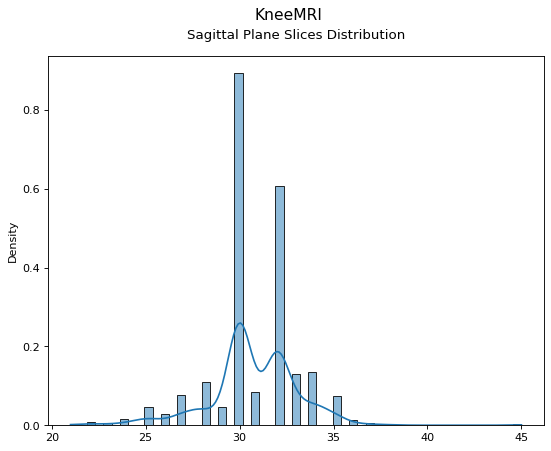

In [124]:
plot_slices_per_exam(mri_vol_paths)

In [125]:
# names=True loads the interprets the first row of csv file as column names
# 'i4' = 4 byte signed integer, 'U20' = unicode max 20 char string
metadata = np.genfromtxt(metadata_csv_path, delimiter=',', names=True,
                         dtype='i4,i4,i4,i4,i4,i4,i4,i4,i4,i4,U20') 

In [126]:
metadata_df = pd.DataFrame(metadata)

In [127]:
metadata_df

,examId,seriesNo,aclDiagnosis,kneeLR,roiX,roiY,roiZ,roiHeight,roiWidth,roiDepth,volumeFilename
0,329637,8,0,1,139,184,14,74,72,3,329637-8.pck
1,390116,9,0,0,113,105,10,83,98,6,390116-9.pck
2,404663,8,1,1,120,117,15,101,115,2,404663-8.pck
3,406320,9,0,0,117,124,12,91,80,3,406320-9.pck
4,412857,8,0,1,122,105,14,83,98,4,412857-8.pck
...,...,...,...,...,...,...,...,...,...,...,...
912,1027212,5,1,1,113,127,16,101,99,3,1027212-5.pck
913,1028019,5,1,1,105,102,14,95,100,3,1028019-5.pck
914,1028028,5,0,0,118,84,15,100,100,2,1028028-5.pck
915,1028069,5,0,0,105,97,15,103,106,4,1028069-5.pck


In [128]:
metadata_df[metadata['examId'] == 329637]

,examId,seriesNo,aclDiagnosis,kneeLR,roiX,roiY,roiZ,roiHeight,roiWidth,roiDepth,volumeFilename
0,329637,8,0,1,139,184,14,74,72,3,329637-8.pck


In [129]:
metadata_df['aclDiagnosis'].value_counts()

aclDiagnosis
0    690
1    172
2     55
Name: count, dtype: int64

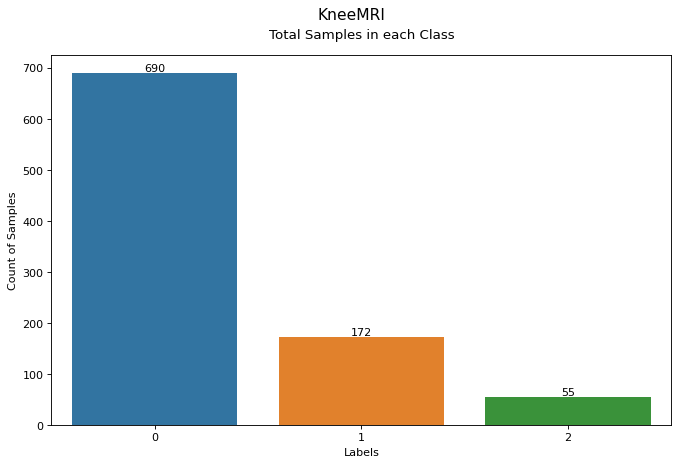

In [130]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=80)
fig.suptitle('KneeMRI', fontsize=14)
ax = sns.barplot(x=metadata_df['aclDiagnosis'].value_counts().index,
                 y=metadata_df['aclDiagnosis'].value_counts(),
                 ax=ax)
ax.bar_label(ax.containers[0])
ax.set_xlabel('Labels')
ax.set_ylabel('Count of Samples')
ax.set_title('Total Samples in each Class', pad=15)
plt.show()

In [131]:
metadata_df['kneeLR'].value_counts()

kneeLR
1    469
0    448
Name: count, dtype: int64

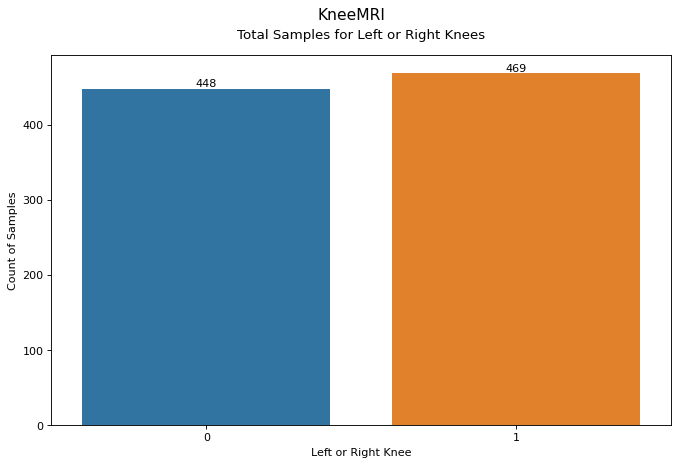

In [132]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=80)
fig.suptitle('KneeMRI', fontsize=14)
ax = sns.barplot(x=metadata_df['kneeLR'].value_counts().index, 
                 y=metadata_df['kneeLR'].value_counts(), 
                 ax=ax)
ax.bar_label(ax.containers[0])
ax.set_xlabel('Left or Right Knee')
ax.set_ylabel('Count of Samples')
ax.set_title('Total Samples for Left or Right Knees', pad=15)
plt.show()

In [133]:
metadata_df['aclDiagnosis'].value_counts(normalize=True)*100

aclDiagnosis
0    75.245365
1    18.756816
2     5.997819
Name: proportion, dtype: float64

In [134]:
metadata_df['kneeLR'].value_counts(normalize=True)

kneeLR
1    0.51145
0    0.48855
Name: proportion, dtype: float64

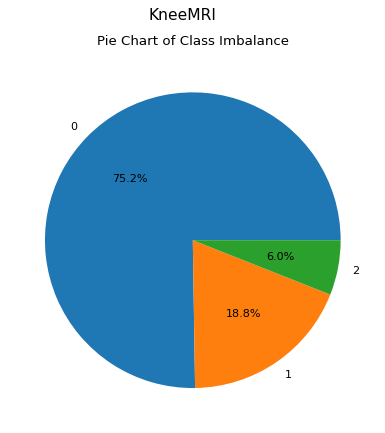

In [135]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=80)
fig.suptitle('KneeMRI', fontsize=14)
ax.pie(x=metadata_df['aclDiagnosis'].value_counts(), 
       labels=metadata_df['aclDiagnosis'].value_counts().index,
       autopct='%.1f%%')
ax.set_title('Pie Chart of Class Imbalance', pad=10)
plt.show()

## EDA After Pre-processing and Data Augmentation

In [139]:
# Directory where the preprocessed volumetric data is located
preprocessed_kneemri_data_dir = '/kaggle/working/Preprocessed_Data/kaggle/input/kneemridataset'
# path to metadata csv file
kneemri_metadata_csv_path = '/kaggle/input/kneemridataset/metadata.csv'
aug_metadata_csv_path = '/kaggle/working/metadata-aug.csv'

# For running code on Windows
if platform.system() == "Windows":
    preprocessed_kneemri_data_dir = preprocessed_kneemri_data_dir.replace('/', '\\')
    kneemri_metadata_csv_path = kneemri_metadata_csv_path.replace('/', '\\')
    aug_metadata_csv_path = aug_metadata_csv_path.replace('/', '\\')

In [142]:
if platform.system() == "Windows":
    mri_vol_paths = glob(preprocessed_kneemri_data_dir + "\\vol*")
else:
    mri_vol_paths = glob(preprocessed_kneemri_data_dir + "/vol*")
mri_vol_paths.sort()
cases = []
for mri_data_path in mri_vol_paths:
    if platform.system() == "Windows":
        all_exams = glob(mri_data_path + "\\*.npy")
    else:
        all_exams = glob(mri_data_path + "/*.npy")
    all_exams.sort()
    cases.extend(all_exams)

In [143]:
aug_cases = []
for mri_data_path in mri_vol_paths:
    if platform.system() == "Windows":
        all_exams = glob(mri_data_path + "\\aug\\*.npy")
    else:
        all_exams = glob(mri_data_path + "/aug/*.npy")
    all_exams.sort()
    aug_cases.extend(all_exams)

In [144]:
filenames = []
filenames.extend(cases)
filenames.extend(aug_cases)
filenames.sort()

In [145]:
len(filenames)

586

In [147]:
# names=True loads the interprets the first row of csv file as column names
# 'i4' = 4 byte signed integer, 'U20' = unicode max 20 char string
metadata = np.genfromtxt(kneemri_metadata_csv_path, delimiter=',', names=True, 
                         dtype='i4,i4,i4,i4,i4,i4,i4,i4,i4,i4,U20')
metadata_df = pd.DataFrame(metadata)
aug_metadata_df = pd.read_csv(aug_metadata_csv_path, index_col=0)
full_metadata_df = pd.concat([metadata_df, aug_metadata_df], ignore_index=True)

In [148]:
len(full_metadata_df)

939

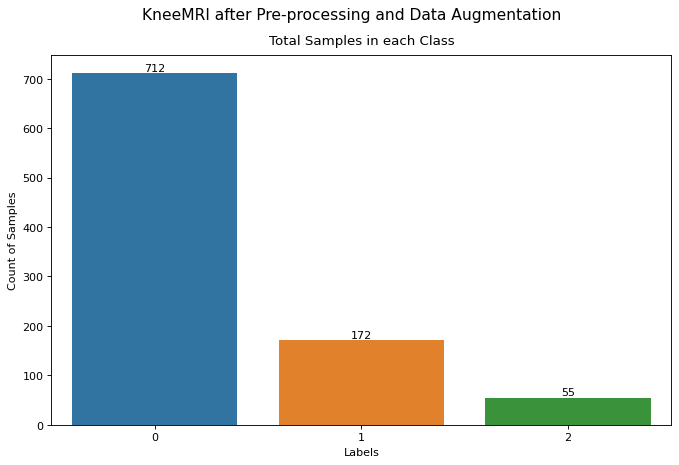

In [149]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=80)
fig.suptitle('KneeMRI after Pre-processing and Data Augmentation', fontsize=14)
ax = sns.barplot(x=full_metadata_df['aclDiagnosis'].value_counts().index, 
                 y=full_metadata_df['aclDiagnosis'].value_counts(), 
                 ax=ax)
ax.bar_label(ax.containers[0])
ax.set_xlabel('Labels')
ax.set_ylabel('Count of Samples')
ax.set_title('Total Samples in each Class', pad=10)
plt.show()

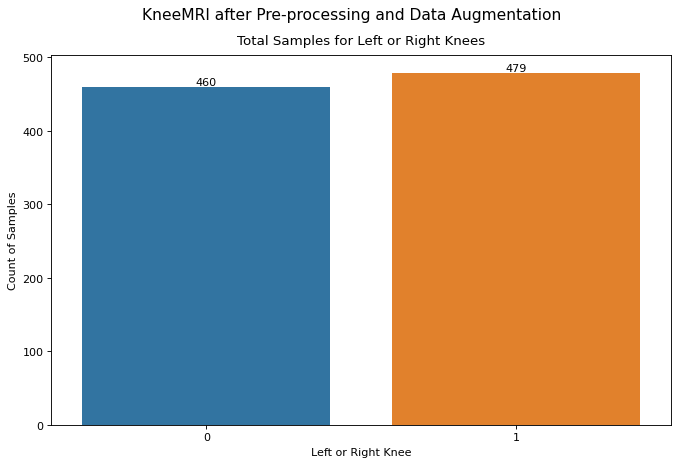

In [150]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=80)
fig.suptitle('KneeMRI after Pre-processing and Data Augmentation', fontsize=14)
ax = sns.barplot(x=full_metadata_df['kneeLR'].value_counts().index, 
                 y=full_metadata_df['kneeLR'].value_counts(), 
                 ax=ax)
ax.bar_label(ax.containers[0])
ax.set_xlabel('Left or Right Knee')
ax.set_ylabel('Count of Samples')
ax.set_title('Total Samples for Left or Right Knees', pad=10)
plt.show()

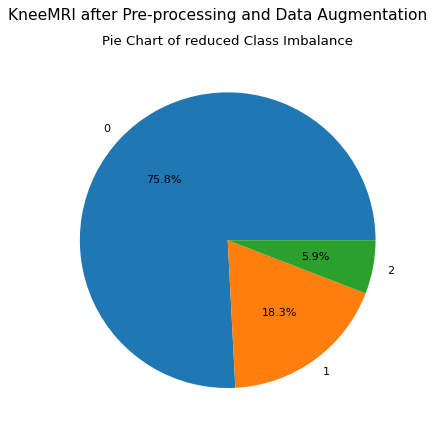

In [151]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=80)
fig.suptitle('KneeMRI after Pre-processing and Data Augmentation', fontsize=14)
ax.pie(x=full_metadata_df['aclDiagnosis'].value_counts(), 
       labels=full_metadata_df['aclDiagnosis'].value_counts().index,
       autopct='%.1f%%')
ax.set_title('Pie Chart of reduced Class Imbalance', pad=10)
plt.show()

# **Model Training**

In [152]:
import platform
import pandas as pd
import numpy as np
from glob import glob

In [153]:
import tensorflow as tf
from tensorflow import keras

2024-08-06 15:17:32.220130: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-06 15:17:32.220259: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-06 15:17:32.348307: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [223]:
from sklearn.model_selection import train_test_split# Directory where the preprocessed volumetric data is located
kneemri_preprocessed_data_dir = '/kaggle/working/Preprocessed_Data/kaggle/input/kneemridataset'
# path to metadata csv file
kneemri_metadata_csv_path = '/kaggle/input/kneemridataset/metadata.csv'
kneemri_aug_metadata_csv_path = '/kaggle/working/metadata-aug.csv'

In [224]:
# For running code on Windows
if platform.system() == "Windows":
    kneemri_preprocessed_data_dir = kneemri_preprocessed_data_dir.replace('/', '\\')
    kneemri_metadata_csv_path = kneemri_metadata_csv_path.replace('/', '\\')
    kneemri_aug_metadata_csv_path = kneemri_aug_metadata_csv_path.replace('/', '\\')

In [225]:
kneemri_classes = { 0:'healthy', 1:'partially ruptured', 2:'completely ruptured'}

In [226]:
if platform.system() == "Windows":
    kneemri_vol_paths = glob(kneemri_preprocessed_data_dir+"\\vol*")
else:
    kneemri_vol_paths = glob(kneemri_preprocessed_data_dir+"/vol*")
kneemri_vol_paths.sort()

In [227]:
kneemri_vol_paths

['/kaggle/working/Preprocessed_Data/kaggle/input/kneemridataset/vol01',
 '/kaggle/working/Preprocessed_Data/kaggle/input/kneemridataset/vol02',
 '/kaggle/working/Preprocessed_Data/kaggle/input/kneemridataset/vol03',
 '/kaggle/working/Preprocessed_Data/kaggle/input/kneemridataset/vol04',
 '/kaggle/working/Preprocessed_Data/kaggle/input/kneemridataset/vol05',
 '/kaggle/working/Preprocessed_Data/kaggle/input/kneemridataset/vol06',
 '/kaggle/working/Preprocessed_Data/kaggle/input/kneemridataset/vol07',
 '/kaggle/working/Preprocessed_Data/kaggle/input/kneemridataset/vol08']

In [228]:
kneemri_cases = []
for mri_data_path in kneemri_vol_paths:
    if platform.system() == "Windows":
        all_exams = glob(mri_data_path+"\\*.npy")
    else:
        all_exams = glob(mri_data_path+"/*.npy")
    all_exams.sort()
    kneemri_cases.extend(all_exams)

In [229]:
print('Original cases : ', len(kneemri_cases))

Original cases :  0


In [234]:
kneemri_cases

[]

In [236]:
kneemri_aug_cases = []
for mri_data_path in kneemri_vol_paths:
    if platform.system() == "Windows":
        all_exams = glob(mri_data_path+"\\aug\\*.npy")
    else:
        all_exams = glob(mri_data_path+"/aug/*.npy")
    all_exams.sort()
    kneemri_aug_cases.extend(all_exams)

In [237]:
print('Augmented cases : ', len(kneemri_aug_cases))

Augmented cases :  586


In [239]:
kneemri_aug_cases

['/kaggle/working/Preprocessed_Data/kaggle/input/kneemridataset/vol01/aug/404663-8-aug-0.npy',
 '/kaggle/working/Preprocessed_Data/kaggle/input/kneemridataset/vol01/aug/404663-8-aug-1.npy',
 '/kaggle/working/Preprocessed_Data/kaggle/input/kneemridataset/vol01/aug/406320-9-aug-0.npy',
 '/kaggle/working/Preprocessed_Data/kaggle/input/kneemridataset/vol01/aug/412865-8-aug-0.npy',
 '/kaggle/working/Preprocessed_Data/kaggle/input/kneemridataset/vol01/aug/412865-8-aug-1.npy',
 '/kaggle/working/Preprocessed_Data/kaggle/input/kneemridataset/vol01/aug/451760-9-aug-0.npy',
 '/kaggle/working/Preprocessed_Data/kaggle/input/kneemridataset/vol01/aug/451760-9-aug-1.npy',
 '/kaggle/working/Preprocessed_Data/kaggle/input/kneemridataset/vol01/aug/454319-8-aug-0.npy',
 '/kaggle/working/Preprocessed_Data/kaggle/input/kneemridataset/vol01/aug/454319-8-aug-1.npy',
 '/kaggle/working/Preprocessed_Data/kaggle/input/kneemridataset/vol01/aug/457491-6-aug-0.npy',
 '/kaggle/working/Preprocessed_Data/kaggle/input/k

In [ ]:
# names=True loads the interprets the first row of csv file as column names
# 'i4' = 4 byte signed integer, 'U20' = unicode max 20 char string
kneemri_metadata = np.genfromtxt(kneemri_metadata_csv_path, delimiter=',', names=True, 
                                 dtype='i4,i4,i4,i4,i4,i4,i4,i4,i4,i4,U20')

In [ ]:
kneemri_metadata_df = pd.DataFrame(kneemri_metadata)

In [ ]:
kneemri_metadata_df

In [ ]:
kneemri_metadata_df.info()

In [ ]:
kneemri_metadata_df['volumeFilename'].nunique()

In [ ]:
kneemri_aug_metadata_df = pd.read_csv(kneemri_aug_metadata_csv_path, index_col=0)

In [ ]:
kneemri_aug_metadata_df

In [ ]:
kneemri_metadata_df[kneemri_metadata_df['examId']==584216]

In [ ]:
kneemri_metadata_df[kneemri_metadata_df['examId']==404663]

In [ ]:
kneemri_aug_metadata_df[kneemri_aug_metadata_df['examId']==404663]

In [ ]:
kneemri_full_metadata_df = pd.concat([kneemri_metadata_df, kneemri_aug_metadata_df], ignore_index=True)

In [ ]:
kneemri_full_metadata_df

In [ ]:
kneemri_filenames = []
kneemri_filenames.extend(kneemri_cases)
kneemri_filenames.extend(kneemri_aug_cases)
kneemri_filenames.sort()

In [ ]:
print(len(kneemri_filenames))

In [ ]:

def get_correct_labels_kneemri(filenames, labels_dataframe):
    """Summary

    Args:
        filenames (list): List of filenames of the MRI scans
        labels_dataframe (pd.Dataframe): Dataframe with all KneeMRI metadata and labels

    Returns:
        list: List of corresponding labels for given KneeMRI case filenames
    """
    labels = []
    for file in filenames:
        name = os.path.normpath(file).split(os.sep)[-1]
        vol_file_name = name.split('.')[0] + '.pck'
        label = labels_dataframe.loc[labels_dataframe['volumeFilename'] == vol_file_name, 'aclDiagnosis'].tolist()[0]
        labels.append(label)
    return labels


In [ ]:
# labels = full_metadata_df['aclDiagnosis'].tolist()
kneemri_labels = get_correct_labels_kneemri.(kneemri_filenames, kneemri_full_metadata_df)

In [ ]:
print(len(kneemri_labels))

In [ ]:
kneemri_filenames[:5]

In [ ]:
kneemri_labels[:5]

In [ ]:
BATCH_SIZE = 8
EPOCHS = 100

In [ ]:
# Quick check of counts of samples for each case
[[x, kneemri_labels.count(x)] for x in set(kneemri_labels)]

In [ ]:
# Splitting into train, test and validation

X, X_test, y, y_test = train_test_split(kneemri_filenames, 
                                        kneemri_labels, 
                                        test_size=0.1, 
                                        random_state=610, 
                                        shuffle=True, 
                                        stratify=kneemri_labels)

X_train, X_valid, y_train, y_valid = train_test_split(X,
                                                      y,
                                                      train_size=0.7, 
                                                      random_state=610, 
                                                      shuffle=True, 
                                                      stratify=y)

In [ ]:
print(len(X))
print(len(X_test))
print(len(y))
print(len(y_test))

In [ ]:
print(len(X_train))
print(len(X_valid))
print(len(y_train))
print(len(y_valid))

In [ ]:
# CASES
print(len(X_train))
print(len(X_test))
print(len(X_valid))
print(len(X_train) + len(X_test) + len(X_valid))

In [ ]:
# LABELS
print(len(y_train))
print(len(y_test))
print(len(y_valid))
print(len(y_train) + len(y_test) + len(y_valid))

In [ ]:
tf.executing_eagerly()

In [ ]:
kneemri_class_weights = utils.compute_class_weights(y_train)

In [ ]:
kneemri_class_weights

## KneeMRI Model 

In [ ]:

def mri_model_6(model_name, num_classes, depth=30, width=256, height=256):
    """Summary

    Args:
        model_name (str): Model name
        num_classes (int): Number of classes
        depth (int, optional): Depth of MRI volume
        width (int, optional): Width of MRI volume
        height (int, optional): Height of MRI volume

    Returns:
        TYPE: Keras Model
    """
    # Determine the number of units and activation function of the last layer
    # based on the input number of classes
    if num_classes == 2:
        last_layer_units = 1
        last_layer_activation = 'sigmoid'
    elif num_classes > 2:
        last_layer_units = num_classes
        last_layer_activation = 'softmax'

    model = Sequential([
        Conv3D(8, kernel_size=(3, 3, 3), padding="same", activation='relu', input_shape=(depth, width, height, 1)),
        Conv3D(16, kernel_size=(3, 3, 3), padding="same", activation='relu'),
        MaxPooling3D(pool_size=(2, 2, 2), padding="same"),
        Conv3D(16, kernel_size=(3, 3, 3), padding="same", activation='relu'),
        Conv3D(16, kernel_size=(3, 3, 3), padding="same", activation='relu'),
        MaxPooling3D(pool_size=(2, 2, 2), padding="same"),
        Conv3D(16, kernel_size=(3, 3, 3), padding="same", activation='relu'),
        Conv3D(16, kernel_size=(3, 3, 3), padding="same", activation='relu'),
        MaxPooling3D(pool_size=(2, 2, 2), padding="same"),
        BatchNormalization(),
        Conv3D(32, kernel_size=(3, 3, 3), padding="same", activation='relu'),
        Conv3D(32, kernel_size=(3, 3, 3), padding="same", activation='relu'),
        MaxPooling3D(pool_size=(2, 2, 2), padding="same"),
        Conv3D(32, kernel_size=(3, 3, 3), padding="same", activation='relu'),
        MaxPooling3D(pool_size=(2, 2, 2), padding="same"),
        BatchNormalization(),
        Conv3D(64, kernel_size=(3, 3, 3), padding="same", activation='relu'),
        MaxPooling3D(pool_size=(2, 2, 2), padding="same"),
        Conv3D(64, kernel_size=(3, 3, 3), padding="same", activation='relu'),
        MaxPooling3D(pool_size=(2, 2, 2), padding="same"),
        Conv3D(64, kernel_size=(3, 3, 3), padding="same", activation='relu'),
        MaxPooling3D(pool_size=(2, 2, 2), padding="same"),
        BatchNormalization(),
        Conv3D(128, kernel_size=(3, 3, 3), padding="same", activation='relu'),
        MaxPooling3D(pool_size=(2, 2, 2), padding="same"),
        Conv3D(128, kernel_size=(3, 3, 3), padding="same", activation='relu'),
        MaxPooling3D(pool_size=(2, 2, 2), padding="same"),
        Conv3D(128, kernel_size=(3, 3, 3), padding="same", activation='relu'),
        MaxPooling3D(pool_size=(2, 2, 2), padding="same"),
        BatchNormalization(),
        Conv3D(256, kernel_size=(3, 3, 3), padding="same", activation='relu'),
        MaxPooling3D(pool_size=(2, 2, 2), padding="same"),
        Conv3D(256, kernel_size=(3, 3, 3), padding="same", activation='relu'),
        MaxPooling3D(pool_size=(2, 2, 2), padding="same"),
        Conv3D(256, kernel_size=(3, 3, 3), padding="same", activation='relu'),
        MaxPooling3D(pool_size=(2, 2, 2), padding="same"),
        Dropout(0.5),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.3),
        Dense(256, activation='relu'),
        Dropout(0.2),
        Dense(128, activation='relu'),
        Dropout(0.1),
        Dense(last_layer_units, activation=last_layer_activation)
    ], name=model_name)

    return model

In [ ]:
model_name = 'kneeMRI_Model'
kneeMRI_Model6 = mri_model_6(model_name, len(kneemri_classes))
kneeMRI_Model6.compile(optimizer=keras.optimizers.Adam(learning_rate=utils.model_lr_schedule()), 
                       loss='sparse_categorical_crossentropy', 
                       metrics=['accuracy'])
kneeMRI_Model6.summary()

In [ ]:
def batch_generator(filenames, labels, batch_size):
    '''
    This function loads the respective filenames and labels in the memory 
    based on the parameter batch size. It helps to control the amount of
    RAM being consumed as the datasets are large.

    Args:
        filenames (list): List of file paths to the MRI
        labels (list): List of corresponding labels of the MRI
        batch_size (int): Batch size

    Yields:
        tuple: Tuple of list of loaded MRI files and corresponding labels
    '''
    N = len(filenames)
    i = 0
    random_state_counter = 610
    filenames, labels = shuffle(filenames, labels, random_state=random_state_counter + 69)  # Shuffle at the start
    while True:
        batch_images = []
        batch_filenames = filenames[i:i + batch_size]
        for file in batch_filenames:
            mri_vol = np.load(file)
            mri_vol = np.expand_dims(mri_vol, axis=3)  # Adding extra axis for making it compatible for 3D Convolutions
            batch_images.append(mri_vol)
        batch_labels = labels[i:i + batch_size]
        batch_images = np.array(batch_images)
        batch_labels = np.array(batch_labels)
        yield (batch_images, batch_labels)
        i = i + batch_size
        if i + batch_size > N:
            i = 0
            random_state_counter += 1
            filenames, labels = shuffle(filenames, labels, random_state=random_state_counter + 69)  # Shuffle at the end of each epoch



In [ ]:


def model_callback_checkpoint(model_name, model_store_path='Models'):
    """Summary

    Args:
        model_name (str): Name of the model
        model_store_path (str, optional): Path to store the models

    Returns:
        TYPE: Keras checkpoint callback to store the best model
    """
    file_name = f"{model_store_path}/{model_name}/{model_name}.h5"

    # For running code on Windows
    if platform.system() == "Windows":
        file_name = file_name.replace('/', '\\')

    checkpoint_callback = keras.callbacks.ModelCheckpoint(file_name,
                                                          save_best_only=True)
    return checkpoint_callback



In [ ]:
%%time
with tf.device('/device:GPU:0'):
    history = kneeMRI_Model6.fit(batch_generator(X_train, y_train, BATCH_SIZE),
                                 steps_per_epoch=len(X_train)//BATCH_SIZE,
                                 epochs=EPOCHS,
                                 validation_data=batch_generator(X_valid, y_valid, BATCH_SIZE),
                                 validation_steps=len(X_valid)//BATCH_SIZE, 
                                 shuffle=True,
                                 class_weight=kneemri_class_weights,
                                 verbose=1,
                                 callbacks=[model_callback_checkpoint(model_name), utils.model_callback_earlystopping()])

In [ ]:


def store_model_history(model_name, model_history, model_history_path='Models'):
    """Summary

    Args:
        model_name (str): Model name
        model_history (TYPE): Keras model history
        model_history_path (str, optional): Path to store model history
    """
    file_name = f"{model_history_path}/{model_name}/{model_name}-history.pck"

    # For running code on Windows
    if platform.system() == "Windows":
        file_name = file_name.replace('/', '\\')

    parent_directory = os.path.dirname(file_name)
    if not os.path.exists(parent_directory):
        os.makedirs(parent_directory, exist_ok=True)

    with open(file_name, 'wb') as fh:
        pickle.dump(model_history, fh)


In [ ]:

def plot_acc_loss(model_history):
    """Summary

    Args:
        model_history (TYPE): Model history
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6), dpi=160)

    acc = model_history['accuracy']
    val_acc = model_history['val_accuracy']

    # Get number of epochs
    epochs = range(1, len(acc) + 1)

    # Plot training and validation accuracy per epoch
    ax1.plot(epochs, acc, label="Training Accuracy")
    ax1.plot(epochs, val_acc, label="Validation Accuracy")
    ax1.set_title('Training and Validation Accuracy')
    ax1.set_xlabel('EPOCHS')
    ax1.set_ylabel('ACCURACY')
    ax1.legend()

    loss = model_history['loss']
    val_loss = model_history['val_loss']
    
    # Plot training and validation loss per epoch
    ax2.plot(epochs, loss, label="Training Loss")
    ax2.plot(epochs, val_loss, label="Validation Loss")
    ax2.set_title('Training and Validation Loss')
    ax2.set_xlabel('EPOCHS')
    ax2.set_ylabel('LOSS')
    ax2.legend()

In [ ]:
# Store history
store_model_history(model_name, history.history)

# Plot training graphs
plot_acc_loss(history.history)

In [ ]:

def load_model_from_disk(model_name, model_store_path='Models'):
    """Summary

    Args:
        model_name (str): Model name
        model_store_path (str, optional): Path to load a model from

    Returns:
        TYPE: Description
    """
    file_name = f"{model_store_path}/{model_name}/{model_name}.h5"

    # For running code on Windows
    if platform.system() == "Windows":
        file_name = file_name.replace('/', '\\')

    if os.path.exists(file_name):
        model = load_model(file_name)
    else:
        print(f"ERROR: Model file {file_name} not found.")
        return None

    return model


In [ ]:
kneeMRI_Model6 = load_model_from_disk('kneeMRI_Model
def predict_batch_generator(filenames, batch_size):
    '''
    This function loads the respective filenames and labels in the memory 
    based on the parameter batch size. It helps to control the amount of
    RAM being consumed as the datasets are large.

    Args:
        filenames (list): List of filenames of MRI
        batch_size (int): Batch size

    Yields:
        list: List of loaded MRIs
    '''
    N = len(filenames)
    i = 0
    while i < N:
        batch_images = []
        batch_filenames = filenames[i:i + batch_size]
        for file in batch_filenames:
            mri_vol = np.load(file)
            mri_vol = np.expand_dims(mri_vol, axis=3)  # Adding extra axis for making it compatible for 3D Convolutions
            batch_images.append(mri_vol)
        batch_images = np.array(batch_images)
        yield batch_images
        i = i + batch_size')

In [ ]:

# Function for Model Evaluation

def evaluate_model(true_labels, predicted_labels, predicted_probs, label_names):
    """Summary

    Args:
        true_labels (list): List of true labels
        predicted_labels (list): List of predicted labels
        predicted_probs (list): List of predicted probabilities
        label_names (list): List of labels
    """
    print('\nEvaluation Metrics:\n')
    # Check for multi-class, else proceed for binary
    if len(label_names) > 2:
        print(f"Balanced Accuracy : {round(balanced_accuracy_score(true_labels, predicted_labels), 2)}")
        print(f"Precision : {round(precision_score(true_labels, predicted_labels, average='weighted'), 2)}")
        print(f"Recall : {round(recall_score(true_labels, predicted_labels, average='weighted'), 2)}")
        print(f"F1 Score: {round(f1_score(true_labels, predicted_labels, average='weighted'), 2)}")
        print(f"ROC AUC Score : {round(roc_auc_score(true_labels, predicted_probs, multi_class='ovr'), 2)}")
    else:
        print(f"Balanced Accuracy : {round(balanced_accuracy_score(true_labels, predicted_labels), 2)}")
        print(f"Precision : {round(precision_score(true_labels, predicted_labels), 2)}")
        print(f"Recall : {round(recall_score(true_labels, predicted_labels), 2)}")
        print(f"F1 Score: {round(f1_score(true_labels, predicted_labels), 2)}")
        print(f"ROC AUC Score : {round(roc_auc_score(true_labels, predicted_probs), 2)}")

    print("\nClassification report : ")
    print(classification_report(true_labels, predicted_labels, target_names=label_names))

    matrix = confusion_matrix(true_labels, predicted_labels)
    print("\nConfusion Matrix : ")
    # print(matrix)
    ConfusionMatrixDisplay(matrix, display_labels=label_names).plot(cmap=plt.cm.Blues)



In [ ]:
# Evaluate model
X_test_prob = kneeMRI_Model6.predict(utils.predict_batch_generator(X_test, BATCH_SIZE))

X_test_pred = X_test_prob.argmax(axis=-1)

evaluate_model(y_test, X_test_pred.tolist(), X_test_prob.tolist(), ['Healthy', 'Partial Tear', 'Complete Tear'])